### Blob Detection using Laplacians of Gaussian and scale-space extrema detection

(-0.5, 359.5, 359.5, -0.5)

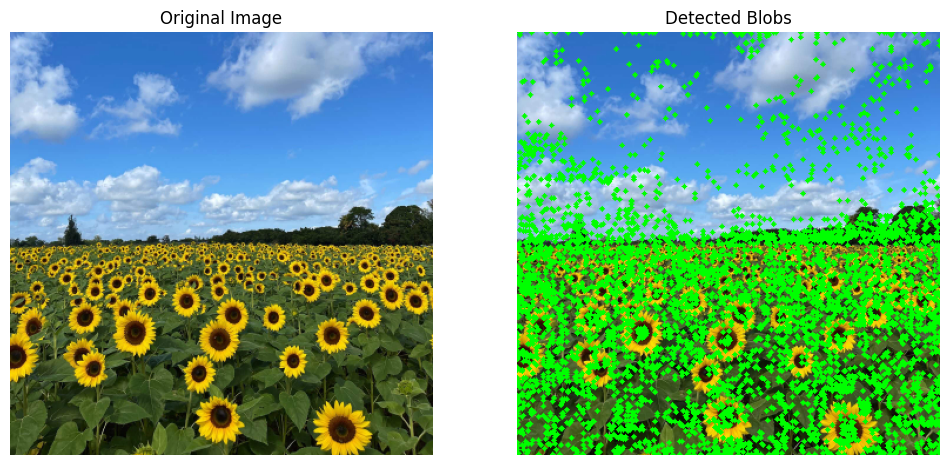

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Load an image
image = cv.imread('Images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Generate blurred images to detect blobs at different scales
sigma_values = np.linspace(1, 50, 10)
blured_images = [cv.GaussianBlur(img_gray, (0, 0), sigma) for sigma in sigma_values]

# Compute the Laplacian of Gaussian 
blobs_log = [cv.Laplacian(img, cv.CV_64F) for img in blured_images]

threshold = 2.98
# Find local extrema across the scale
def blob_detector(images,sigma_values,threshold):
    blobs = []
    blob_radii = []

    for i in range(1, len(images)-1):
        cur, prev, nxt = images[i], images[i-1], images[i+1]
        extrema = np.logical_and(np.logical_and(cur > prev, cur > nxt), cur > threshold)
        y_x = np.argwhere(extrema)  # centers of the blobs
        if y_x.size > 0:
            blobs.append(y_x)
            blob_radii.append(sigma_values[i] * np.sqrt(2))  # Append radii for each detected blob

    return blobs, blob_radii

blobs, blob_radii = blob_detector(blobs_log, sigma_values, threshold)

output_image = image.copy()
output_image = cv.cvtColor(output_image,cv.COLOR_BGR2RGB)

# Draw circles around detected blobs
for i, centers in enumerate(blobs):
    for center in centers:
        cv.circle(output_image, (int(center[1]), int(center[0])), 2, (0, 255, 0), -1)

# Display the image with detected blobs
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_rgb, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(output_image, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Detected Blobs')
ax[1].axis('off')



### Fitting lines

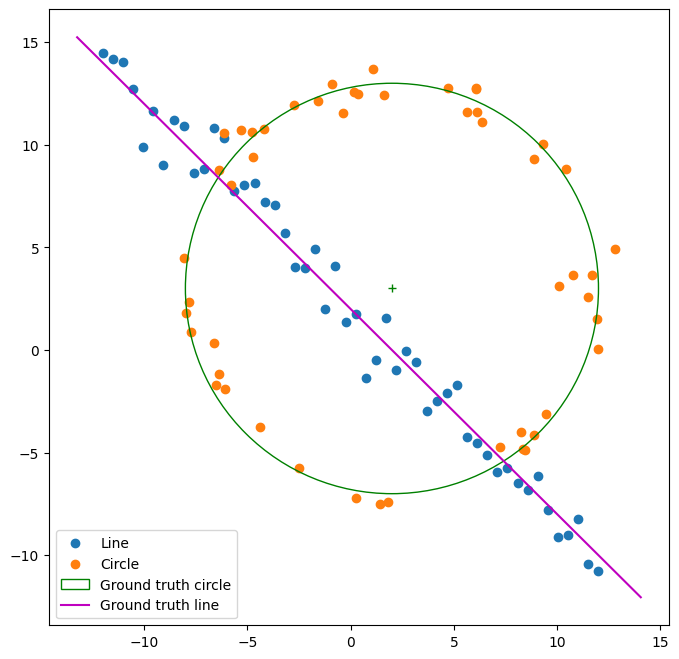

In [60]:
#Listing 1 to generate noisy points
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random . seed ( 0 )
N = 100
half_n = N//2

r = 10
x0_gt,y0_gt = 2,3 # Center
s = r/16
t = np.random.uniform(0,2*np.pi,half_n)
n = s*np.random.randn(half_n)
x,y = x0_gt + (r + n)*np.cos(t),y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
s = 1.
m,b = -1, 2
x = np.linspace (-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack ((x.reshape(half_n, 1), y.reshape(half_n,1)))
X = np.vstack((X_circ, X_line)) # All points
fig , ax = plt.subplots(1 ,1 , figsize=(8 ,8))
ax.scatter(X_line[:, 0], X_line[:, 1], label= 'Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label= 'Circle')
circle_gt = plt.Circle((x0_gt , y0_gt), r, color= 'g' , fill = False , label= 'Ground truth circle' )
ax.add_patch (circle_gt)
ax.plot ((x0_gt ) , (y0_gt) , '+' , color= 'g')
x_min , x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_+b
plt . plot(x_, y_ ,color= 'm' , label= 'Ground truth line' )
plt . legend ( )

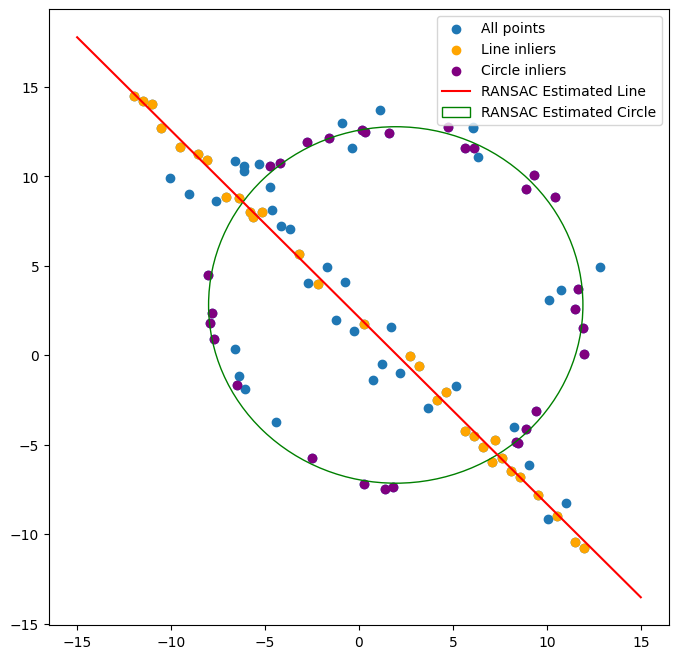

In [64]:
def estimate_circle_ransac(X, threshold, iterations):
    best_inliers = []
    best_circle = None

    for _ in range(iterations):
        # Randomly sample three points to define a circle
        sample_indices = np.random.choice(X.shape[0], 3, replace=False)
        pts = X[sample_indices]

        # Estimate circle parameters using the three points
        A = 2 * (pts[1] - pts[0])
        B = 2 * (pts[2] - pts[0])
        C = np.array([np.sum(pts[1]**2 - pts[0]**2), np.sum(pts[2]**2 - pts[0]**2)])

        try:
            center = np.linalg.solve(np.array([A, B]), C)
            radius = np.linalg.norm(center - pts[0])
        except np.linalg.LinAlgError:
            continue

        # Compute distances to the circle and count inliers
        distances = np.abs(np.sqrt((X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2) - radius)
        inliers = X[distances < threshold]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (center, radius)

    return best_circle[0], best_circle[1], np.array(best_inliers)

# Main execution
params_line, line_inliers = estimate_line_ransac(X, threshold=0.5, iterations=1000)
center_circle, radius_circle, circle_inliers = estimate_circle_ransac(X[~np.isin(X, line_inliers).all(axis=1)], threshold=0.5, iterations=1000)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='All points')
ax.scatter(line_inliers[:, 0], line_inliers[:, 1], label='Line inliers', color='orange')
ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], label='Circle inliers', color='purple')

# Plot line
a, b, d = params_line
x_line = np.linspace(-15, 15, 100)
y_line = -(a * x_line + d) / b
ax.plot(x_line, y_line, color='red', label='RANSAC Estimated Line')

# Plot circle
circle = plt.Circle(center_circle, radius_circle, color='green', fill=False, label='RANSAC Estimated Circle')
ax.add_patch(circle)

plt.legend()
plt.show()


### Superimpose images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

N = 4 # Number of points
n = 0

# Parameters of the two images
p = np.empty((N,2))
p_flag = np.empty((N,2))

# Mouse callback function
def draw(event,x,y,flags,param):
    global n
    p = param[0]
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(param[1],(x,y),5,(255,0,0),-1)
        p[n] = (x,y)
        n += 1

# Importing the images and creating copies
image_background = cv.imread(r'Images/005.jpg', cv.IMREAD_COLOR)
image_superimposed = cv.imread(r"Images/flag.png", cv.IMREAD_COLOR)
image_background_copy = image_background.copy()
image_superimposed_copy = image_superimposed.copy()

# Getting the mouse points of the base image
cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
param = [p, image_background_copy]
cv.setMouseCallback('Image',draw, param)
while(1):
    cv.imshow('Image', image_background_copy)
    if n == N:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break
cv.destroyAllWindows()

# Automatically get the corners of the flag image
h, w = image_superimposed.shape[:2]
p_flag[0] = [0, 0]               # Top-left corner
p_flag[1] = [w - 1, 0]           # Top-right corner
p_flag[2] = [w - 1, h - 1]       # Bottom-right corner
p_flag[3] = [0, h - 1]           # Bottom-left corner


h, status = cv.findHomography(p, p_flag) # Calculating homography between image and flag

# Warping image of flag
warped_img = cv.warpPerspective(image_superimposed, np.linalg.inv(h), (image_background.shape[1],image_background.shape[0])) 

blended = cv.addWeighted(image_background, 0.5, warped_img, 0.9, 0.0)
fig, ax = plt.subplots(1,1,figsize= (8,8))
ax.imshow(cv.cvtColor(blended,cv.COLOR_BGR2RGB))

# Plotting the results
fig,ax=plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(cv.cvtColor(image_background,cv.COLOR_BGR2RGB))
ax[0].set_title("Source Image")
ax[1].imshow(cv.cvtColor(image_superimposed,cv.COLOR_BGR2RGB))
ax[1].set_title("Flag Image")
ax[2].imshow(cv.cvtColor(blended,cv.COLOR_BGR2RGB))
ax[2].set_title("Final Image")

KeyboardInterrupt: 

In [ ]:
import cv2 as cv
import numpy as np

# Read the background and logo images
img3 = cv.imread("Images/005.jpg")
logo = cv.imread("Images/flag.png")

# Check if images are loaded correctly
if img3 is None or logo is None:
    print("Error: One or both images not found or path is incorrect.")
    exit()

# Print image dimensions for debugging
print(f"Background image shape: {img3.shape}")
print(f"Logo image shape: {logo.shape}")

# Store clicked points for the destination
dst_points = []

# Mouse callback function to store points
def click_event(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        if len(dst_points) < 4:  # We only need 4 points
            dst_points.append((x, y))
            cv.circle(img3, (x, y), 5, (0, 0, 255), -1)
            print(f"Point {len(dst_points)}: ({x}, {y})")  # Print point for debugging
            cv.imshow("Select 4 Points", img3)
        if len(dst_points) == 4:
            cv.destroyWindow("Select 4 Points")

# Display the image and set the mouse callback
cv.imshow("Select 4 Points", img3)
cv.setMouseCallback("Select 4 Points", click_event)
cv.waitKey(0)

# Check if we have exactly 4 points
if len(dst_points) != 4:
    print("Error: You need to select exactly 4 points.")
    exit()

# Convert destination points to numpy array
dst_points = np.array(dst_points, dtype=np.float32)

# Define the source points (corners of the logo)
y, x, _ = logo.shape
src_points = np.array([[0, y], [x, y], [x, 0], [0, 0]], dtype=np.float32)

# Calculate the perspective transformation matrix
M = cv.getPerspectiveTransform(src_points, dst_points)
print("Transformation matrix:\n", M)  # Print matrix for debugging

# Warp the logo to fit into the selected region in the background image
tf_img = cv.warpPerspective(logo, M, (img3.shape[1], img3.shape[0]))

# Display the transformed logo for debugging
cv.imshow("Transformed Logo", tf_img)
cv.waitKey(0)

# Create a mask for blending based on the non-black pixels in the transformed logo
logo_gray = cv.cvtColor(tf_img, cv.COLOR_BGR2GRAY)
_, mask = cv.threshold(logo_gray, 1, 255, cv.THRESH_BINARY)

# Display mask for debugging
cv.imshow("Mask", mask)
cv.waitKey(0)

# Invert the mask to select the background region
mask_inv = cv.bitwise_not(mask)

# Black-out the area of the logo in the background image
img3_bg = cv.bitwise_and(img3, img3, mask=mask_inv)

# Take only the logo region from the transformed image
logo_fg = cv.bitwise_and(tf_img, tf_img, mask=mask)

# Add the background and logo regions
final_img = cv.add(img3_bg, logo_fg)

# Display the final image
cv.imshow("Final Image", final_img)
cv.waitKey(0)
cv.destroyAllWindows()




Background image shape: (768, 1024, 3)
Logo image shape: (960, 1920, 3)
